In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import talib

In [166]:
plt.rcParams['figure.figsize'] = [16, 12]
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Check performance Golder Cross vs Buy and Hold

## Lets get sample data

Get only first day each month, with assumption we buy around RP 1.000.000 each month in first day market open

In [177]:
def get_data(symbol, get_first=True):
    df = pd.read_csv(f'https://raw.githubusercontent.com/faisalburhanudin/idx/master/stocks/{symbol}.csv')
    
    df['Month'] = pd.DatetimeIndex(df['Date']).month
    df['Year'] = pd.DatetimeIndex(df['Date']).year
    df['Day'] = pd.DatetimeIndex(df['Date']).day
    
    if get_first:
        return df.groupby(['Year', 'Month'], as_index=False).first()
    else:
        return df

In [178]:
data = get_data('BBRI')
data.head()

,Year,Month,Date,Open,High,Low,Close,Adj Close,Volume,Day
0,2003,11,2003-11-10,105.000,110.000,95.000,97.500,1.477,5144140000,10
1,2003,12,2003-12-01,105.000,107.500,105.000,107.500,1.629,754210000,1
2,2004,1,2004-01-02,125.000,127.500,122.500,127.500,1.932,228115000,2
3,2004,2,2004-02-03,140.000,140.000,135.000,137.500,2.084,587990000,3
4,2004,3,2004-03-01,155.000,160.000,152.500,160.000,2.424,211110000,1


## Show closing price

In [27]:
def plt_close(df):
    plt.xticks([])
    plt.plot(df['Date'], df['Close'])
    plt.show()

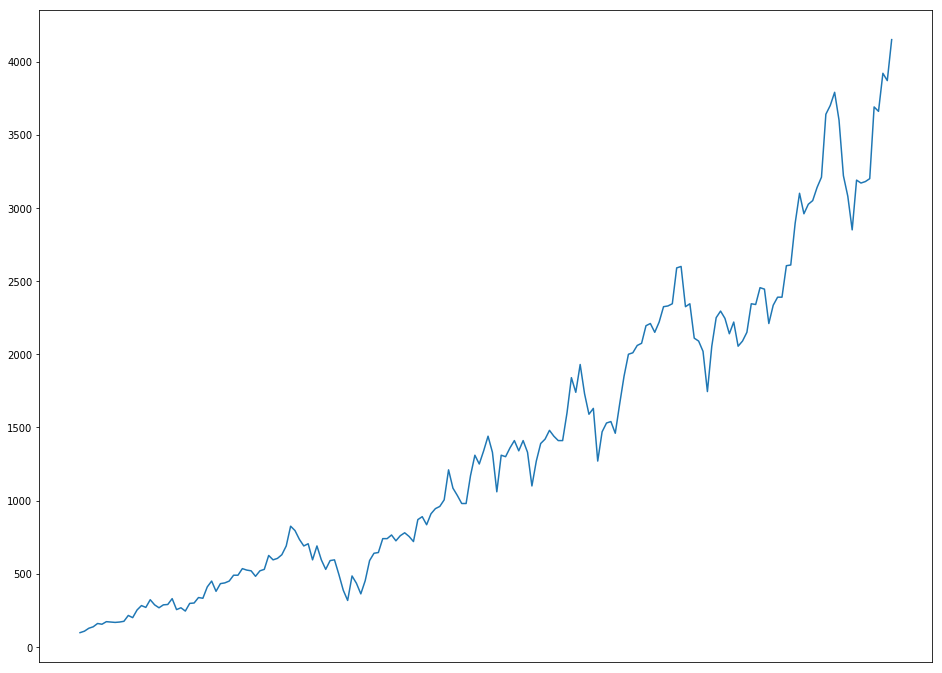

In [28]:
plt_close(data)

## Buy and Hold

Buy Rp 1.000.000 each month

In [125]:
def buy_and_hold(df):
    df = df.copy()
    df = df[['Date', 'Close']]
    df['PerLot'] = df['Close'].apply(lambda x: np.multiply(x, 100))
    
    # first record
    df.loc[0, 'Money'] = 1_000_000
    df.loc[0, 'BuyShare'] = 1_000_000 // df.loc[0, 'PerLot'] * 100
    df.loc[0, 'BuyCost'] = df.loc[0, 'BuyShare'] * df.loc[0, 'Close']
    df.loc[0, 'Left'] = 1_000_000 - df.loc[0, 'BuyCost']
    
    # rest of te record
    df.loc['Money'] = 1_000_000 + df.loc[1:, 'Left'].shift(-1)
    
    return df

In [139]:
data.shape[0] * np.NAN

nan

In [170]:
def buy_and_hold(df, per_month=1_000_000):
    df_len = df.shape[0]
    
    # default value
    date = df['Date']
    close = df['Close']
    per_lot = close * 100
    money = np.zeros(df_len)
    buy_share = np.zeros(df_len)
    buy_cost = np.zeros(df_len)
    left = np.zeros(df_len)
    total_share = np.zeros(df_len)
    value = np.zeros(df_len)
    
    # first month
    money[0] = per_month
    buy_share[0] = per_month // per_lot[0] * 100
    buy_cost[0] = buy_share[0] * close[0]
    left[0] = per_month - buy_cost[0]
    total_share[0] = buy_share[0]
    value[0] = total_share[0] * close[0]
    
    # the rest
    for i in range(1, df_len):
        money[i] = per_month + left[i - 1]
        buy_share[i] = money[i] // per_lot[i] * 100
        buy_cost[i] = buy_share[i] * close[i]
        left[i] = money[i] - buy_cost[i]
        total_share[i] = total_share[i - 1] + buy_share[i]
        value[i] = total_share[i] * close[i]
    
    return pd.DataFrame({
        'Date': df['Date'],
        'Close': df['Close'],
        'PerLot': per_lot,
        'Money': money,
        'BuyShare': buy_share,
        'BuyCost': buy_cost,
        'Left': left,
        'TotalShare': total_share,
        'Value': value
    })

bnh = buy_and_hold(data)
bnh[['Date', 'Close', 'Value', 'TotalShare']].head()

,Date,Close,Value,TotalShare
0,2003-11-10,97.500,994500.000,10200.000
1,2003-12-01,107.500,2096250.000,19500.000
2,2004-01-02,127.500,3480750.000,27300.000
3,2004-02-03,137.500,4757500.000,34600.000
4,2004-03-01,160.000,6528000.000,40800.000


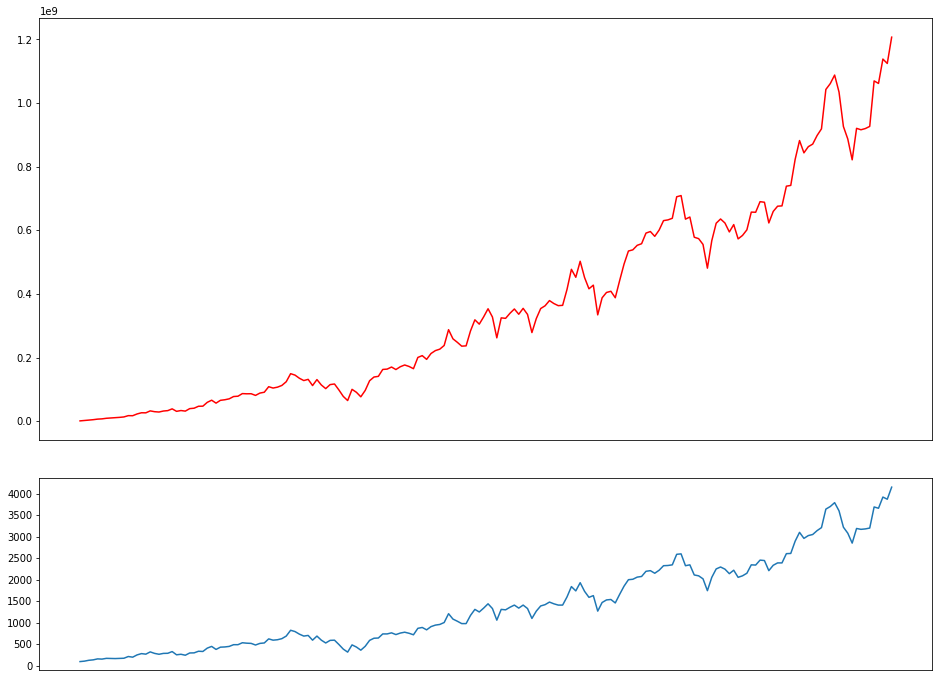

In [176]:
ax0 = plt.subplot2grid((3,1), (0,0), rowspan=2)
ax0.plot(bnh['Date'], bnh['Value'], color='r')

ax1 = plt.subplot2grid((3,1), (2,0), sharex=ax0)
ax1.plot(bnh['Date'], bnh['Close'])

plt.xticks([])
plt.show()

## Golden Cross

If signal sell, sell all stock and save money for buy when there is singnal to buy

In [179]:
data = get_data('BBRI', get_first=False)

In [193]:
def golden(df):
    df_len = df.shape[0]
    
    date = df['Date']
    close = df['Close']
    
    ma_50 = talib.SMA(close, timeperiod=50)
    ma_200 = talib.SMA(close, timeperiod=200)
    signal = np.full(df_len, np.nan)
    
    for i in range(df_len):
        if ma_50[i] > ma_200[i]:
            signal[i] = 1
        if ma_50[i] < ma_200[i]:
            signal[i] = 0
    
    return pd.DataFrame({
        'Date': date,
        'Close': close,
        'MA50': ma_50,
        'MA200': ma_200,
        'Signal': signal
    })

gcr = golden(data)
gcr.head()

,Date,Close,MA50,MA200,Signal
0,2003-11-10,97.500,nan,nan,nan
1,2003-11-11,100.000,nan,nan,nan
2,2003-11-12,105.000,nan,nan,nan
3,2003-11-13,105.000,nan,nan,nan
4,2003-11-14,105.000,nan,nan,nan


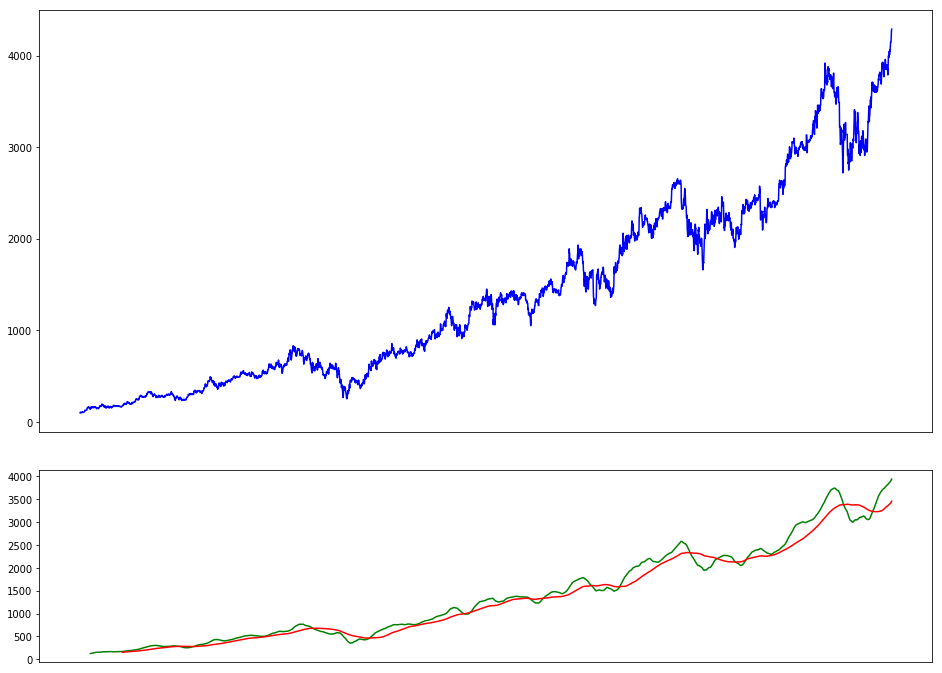

In [208]:
ax0 = plt.subplot2grid((3,1), (0,0), rowspan=2)
ax0.plot(gcr['Date'], gcr['Close'], color='b')

ax1 = plt.subplot2grid((3,1), (2,0), sharex=ax0)
ax1.plot(gcr['Date'], gcr['MA50'], color='g')
ax1.plot(gcr['Date'], gcr['MA200'], color='r')

plt.xticks([])
plt.show()